C:\Users\dylan\AppData\Local\Temp\ipykernel_39904\1099604287.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  logins_15min = logins.resample('15T').count()


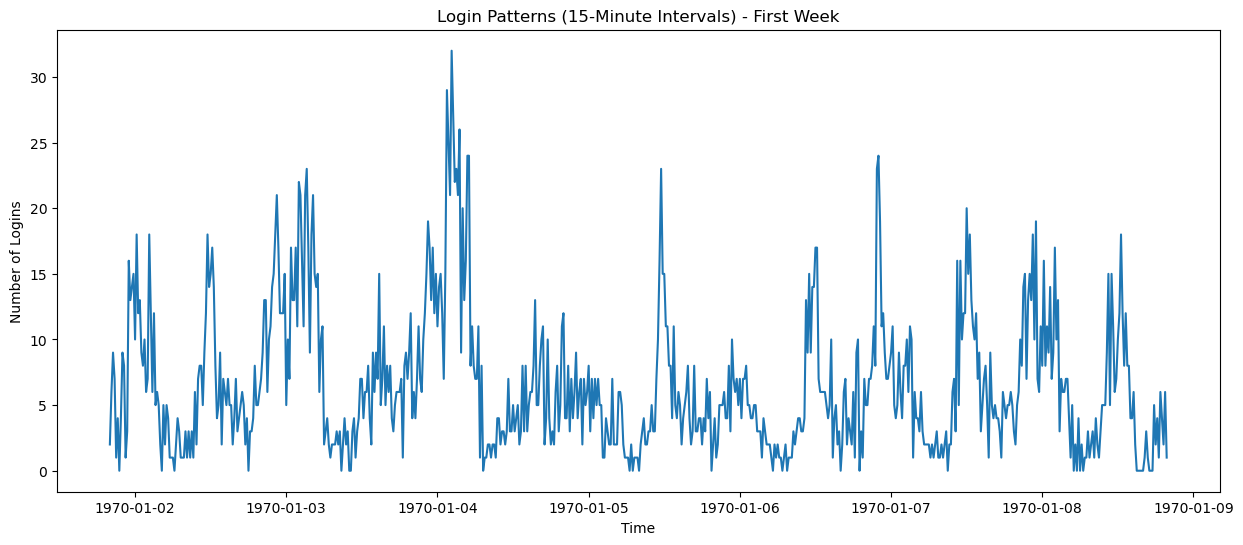

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the login data
# Note: logins.json is usually a single column of timestamps
logins = pd.read_json('logins.json')

# 2. Convert to datetime and set as index
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)
logins['count'] = 1

# 3. Aggregate in 15-minute intervals
logins_15min = logins.resample('15T').count()

# 4. Visualize the first week of data to see patterns
plt.figure(figsize=(15,6))
plt.plot(logins_15min.head(672)) # 672 intervals = 1 week
plt.title('Login Patterns (15-Minute Intervals) - First Week')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.show()

In [3]:
import json

# 1. Load the data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# 2. Convert date strings to datetime objects
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# 3. Define "Active User"
# Determine the most recent trip in the dataset
latest_date = df['last_trip_date'].max()
# Active = took a trip in the 30 days preceding the latest date
df['active'] = (df['last_trip_date'] > (latest_date - pd.Timedelta(days=30))).astype(int)

# 4. Basic Feature Engineering
# Convert 'city' and 'phone' to dummy variables
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# 5. Check Retention Rate
retention_rate = df['active'].mean() * 100
print(f"User Retention Rate: {retention_rate:.2f}%")

User Retention Rate: 36.62%


Model Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6322
           1       0.74      0.66      0.70      3678

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



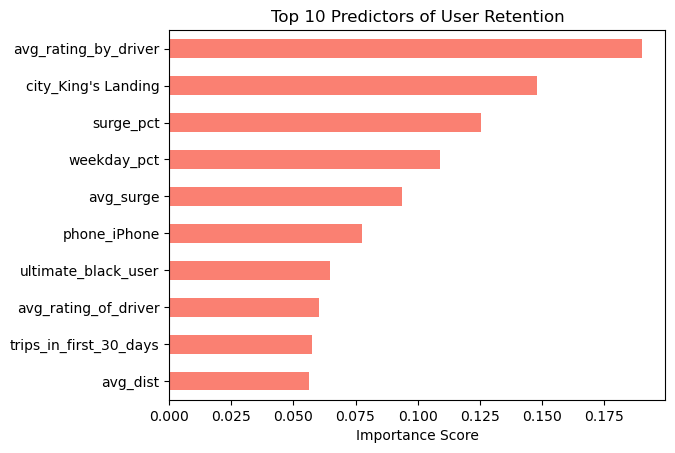

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. LOAD AND PREPARE DATA
# Note: Adjust paths if your files are in a subfolder (e.g., 'data/logins.json')
with open('ultimate_data_challenge.json') as f:
    import json
    data = json.load(f)
df = pd.DataFrame(data)

# Convert dates
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# 2. DEFINE TARGET (RETENTION)
# A user is 'retained' if they took a trip in the preceding 30 days
latest_date = df['last_trip_date'].max()
cutoff_date = latest_date - pd.Timedelta(days=30)
df['retained'] = (df['last_trip_date'] > cutoff_date).astype(int)

# 3. FEATURE ENGINEERING & CLEANING
# Fill missing 'phone' values with 'Other'
df['phone'] = df['phone'].fillna('Other')

# Convert 'ultimate_black_user' to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# One-hot encode categorical variables (City and Phone)
df_encoded = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Drop timestamps and ID-like columns for modeling
X = df_encoded.drop(['last_trip_date', 'signup_date', 'retained'], axis=1)
y = df_encoded['retained']

# 4. TRAIN THE MODEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# 5. EVALUATE & FIND IMPORTANT FEATURES
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Feature Importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).sort_values().plot(kind='barh', color='salmon')
plt.title('Top 10 Predictors of User Retention')
plt.xlabel('Importance Score')
plt.show()